In [33]:
#%matplotlib widget
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import pack_vis_sol
import matplotlib.pyplot as plti
import numpy as np
importlib.reload(kgs)
#pack_vis.plot_polygons([kgs.center_tree] + kgs.convex_breakdown)

local


<module 'kaggle_support' from '/mnt/d/packing/code/analysis/../core/kaggle_support.py'>

In [34]:
# Compare final scores across multiple seeds
SEEDS_TO_DO = [114,115]
TREES_TO_DO = np.arange(20,201,2)
#SEEDS_TO_DO = [110,111]

import numpy as np
import glob
import matplotlib.pyplot as plt
import re

res = []
for s in SEEDS_TO_DO:
    res.append([])
    for N_trees in TREES_TO_DO:
        f = kgs.temp_dir+f'controller_runs/done/ga_N{N_trees}_seed{s}_done.pickle'
        dat = kgs.dill_load(f)
        res[-1].append(dat.ga.champions[0].phenotype.h[0,0].get()**2/N_trees)

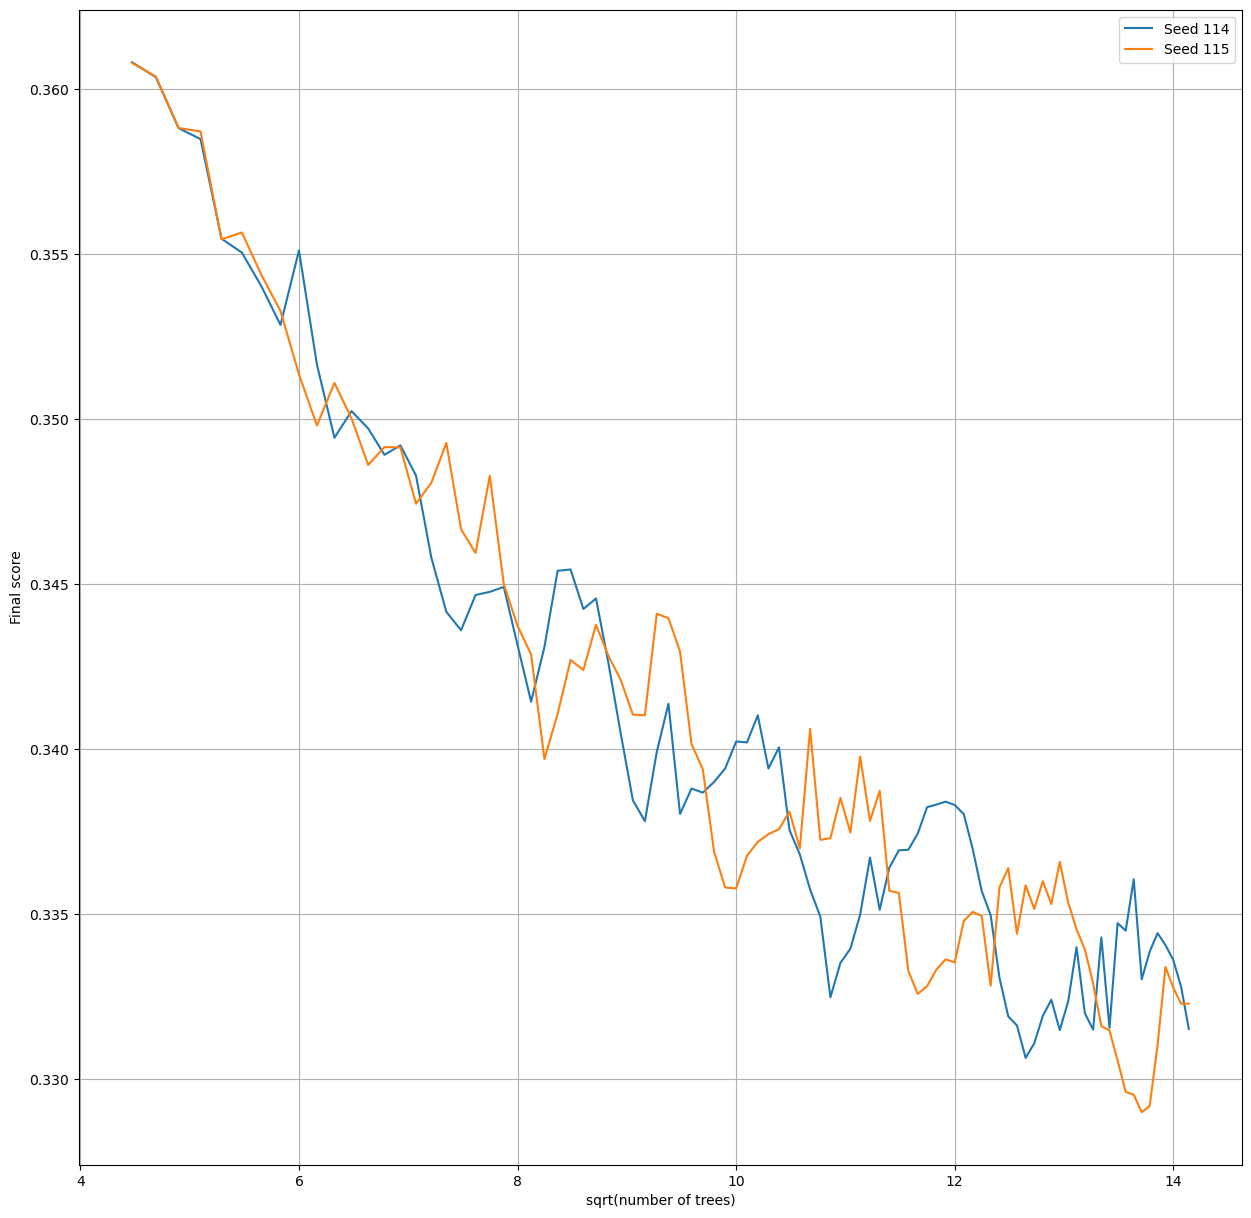

In [35]:
plt.figure(figsize=(15,15))
for i, s in enumerate(SEEDS_TO_DO):
    plt.plot(np.sqrt(TREES_TO_DO), res[i], label=f'Seed {s}')
plt.xlabel('sqrt(number of trees)')
plt.ylabel('Final score')
plt.legend()
plt.grid(True)

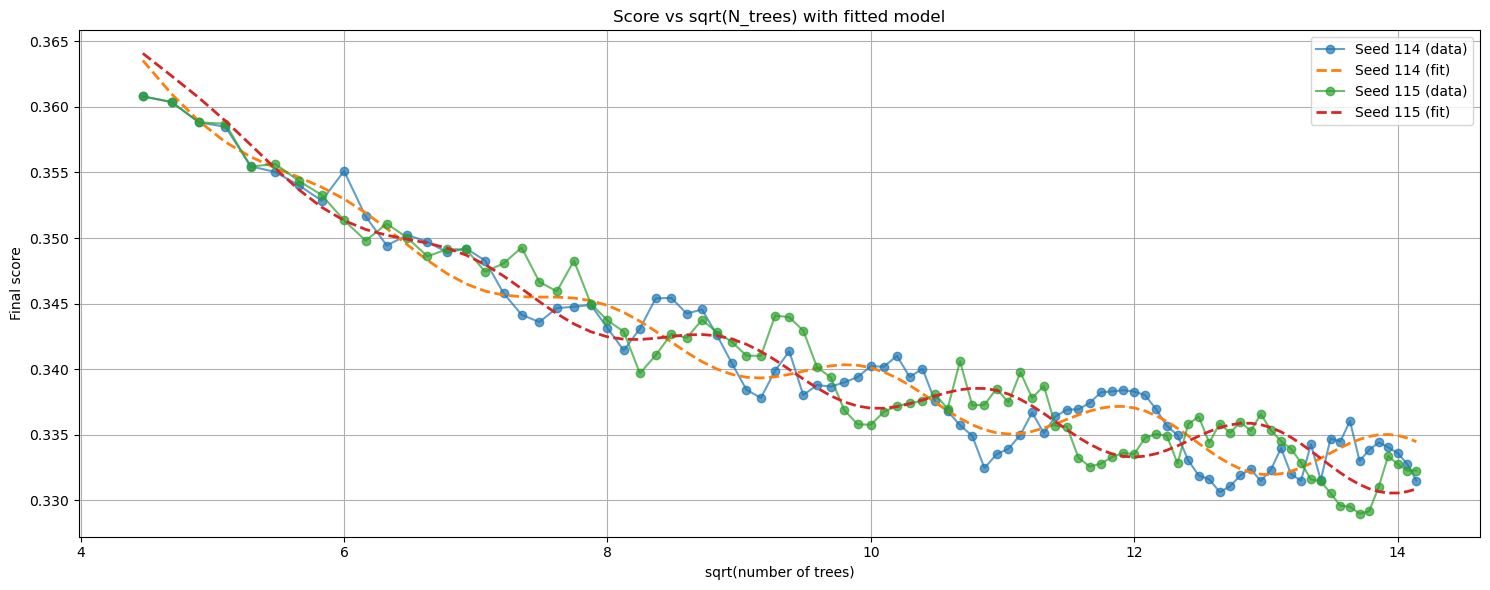

In [58]:
# do a linear fit (independent per seed) of score = a/sqrt(N_trees) + b + c*sin(pi*sqrt(N_trees)) + d*cos(pi*sqrt(N_trees))
# use sklearn

from sklearn.linear_model import LinearRegression

sqrt_N_trees = np.sqrt(TREES_TO_DO)

# Create feature matrix: [1/sqrt(N_trees), 1, sin(pi*sqrt(N_trees)), cos(pi*sqrt(N_trees))]
X = np.column_stack([
    1.0 / sqrt_N_trees,
    np.ones_like(sqrt_N_trees),
    sqrt_N_trees*np.sin(np.pi * sqrt_N_trees),
    sqrt_N_trees*np.cos(np.pi * sqrt_N_trees)
])

# Fit model for each seed
models = []
for i, s in enumerate(SEEDS_TO_DO):
    model = LinearRegression()
    model.fit(X[:-5], res[i][:-5])
    models.append(model)
    
    # Print results
    # print(f"Seed {s}:")
    # print(f"  a (1/sqrt(N)) coefficient: {model.coef_[0]:.6f}")
    # print(f"  b (constant) coefficient: {model.coef_[1]:.6f}")
    # print(f"  c (sin) coefficient: {model.coef_[2]:.6f}")
    # print(f"  d (cos) coefficient: {model.coef_[3]:.6f}")
    # print(f"  R² score: {model.score(X, res[i]):.6f}")
    # print()

# Plot fitted curves
plt.figure(figsize=(15, 6))
for i, s in enumerate(SEEDS_TO_DO):
    y_pred = models[i].predict(X)
    plt.plot(sqrt_N_trees, res[i], 'o-', label=f'Seed {s} (data)', alpha=0.7)
    plt.plot(sqrt_N_trees, y_pred, '--', label=f'Seed {s} (fit)', linewidth=2)

plt.xlabel('sqrt(number of trees)')
plt.ylabel('Final score')
plt.legend()
plt.grid(True)
plt.title('Score vs sqrt(N_trees) with fitted model')
plt.tight_layout()


Seed 114 (with fitted frequency and amplitude scaling):
  a (1/sqrt(N)) coefficient: 0.223445
  b (constant) coefficient: 0.316225
  c (sin) coefficient: -0.000558
  d (cos) coefficient: 0.000376
  ω (frequency): 3.617403
  (frequency/π): 1.151455
  α (amplitude exponent): 0.496936
  Harmonic amplitude: 0.000673
  Phase (radians): 2.548144
  Phase (degrees): 146.00
  R² score: 0.958632

Seed 115 (with fitted frequency and amplitude scaling):
  a (1/sqrt(N)) coefficient: 0.227982
  b (constant) coefficient: 0.315972
  c (sin) coefficient: 0.000155
  d (cos) coefficient: 0.000113
  ω (frequency): 3.519939
  (frequency/π): 1.120431
  α (amplitude exponent): 1.009518
  Harmonic amplitude: 0.000192
  Phase (radians): 0.629500
  Phase (degrees): 36.07
  R² score: 0.961321



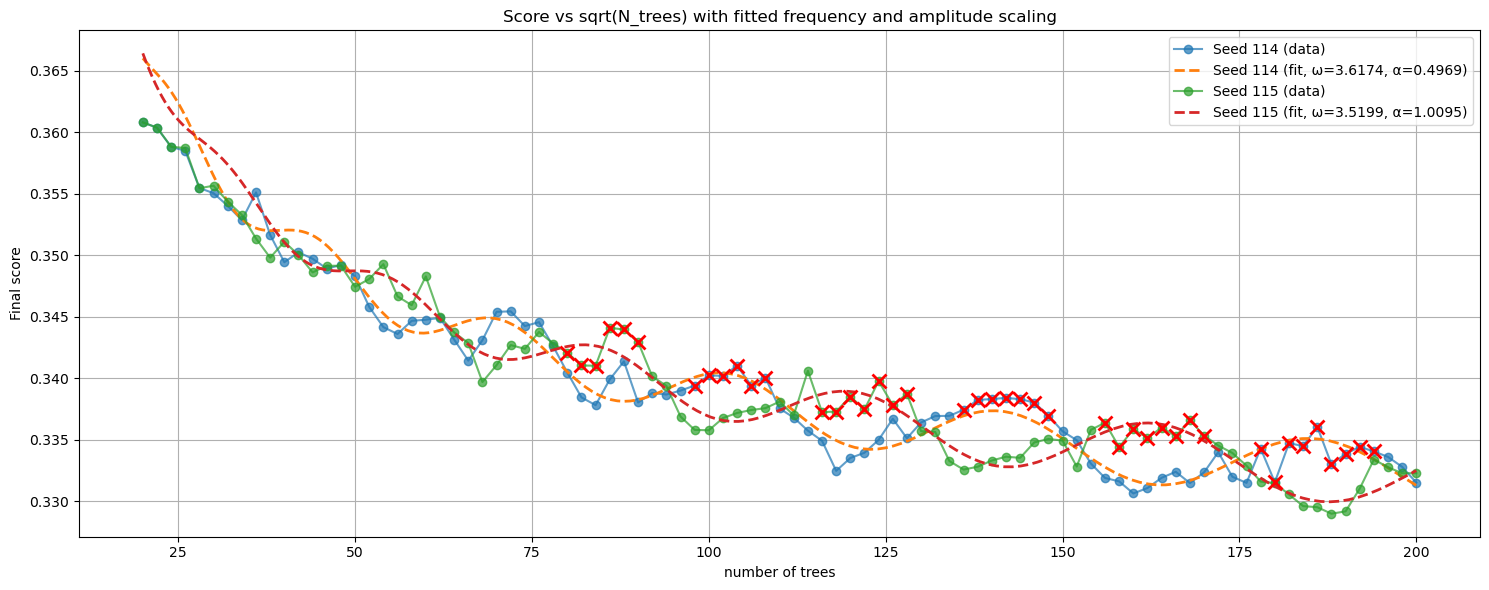

In [68]:
from scipy.optimize import curve_fit

# Define the model function with frequency and amplitude scaling as parameters
def model(sqrt_N, a, b, c, d, omega, alpha):
    amplitude = sqrt_N ** alpha
    return a / sqrt_N + b + amplitude * (c * np.sin(omega * sqrt_N) + d * np.cos(omega * sqrt_N))

sqrt_N_trees = np.sqrt(TREES_TO_DO)

# Fit with frequency and amplitude exponent as constrained parameters
fitted_params = []
for i, s in enumerate(SEEDS_TO_DO):
    # Bounds: (a_min, b_min, c_min, d_min, omega_min, alpha_min) to (max...)
    bounds = ([-np.inf, -np.inf, -np.inf, -np.inf, 2.0, 0.0], 
              [np.inf, np.inf, np.inf, np.inf, 4.5, 2.0])  # Keep omega [2, 4.5] and alpha [0, 2]
    
    try:
        popt, pcov = curve_fit(
            model, 
            sqrt_N_trees[15:-5], 
            res[i][15:-5],
            p0=[models[i].coef_[0], models[i].coef_[1], models[i].coef_[2], models[i].coef_[3], np.pi, 1.0],
            bounds=bounds,
            maxfev=5000
        )
        fitted_params.append(popt)
        
        # Calculate R² manually
        y_pred = model(sqrt_N_trees, *popt)
        ss_res = np.sum((np.array(res[i]) - y_pred) ** 2)
        ss_tot = np.sum((np.array(res[i]) - np.mean(res[i])) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        
        # Print results
        print(f"Seed {s} (with fitted frequency and amplitude scaling):")
        print(f"  a (1/sqrt(N)) coefficient: {popt[0]:.6f}")
        print(f"  b (constant) coefficient: {popt[1]:.6f}")
        print(f"  c (sin) coefficient: {popt[2]:.6f}")
        print(f"  d (cos) coefficient: {popt[3]:.6f}")
        print(f"  ω (frequency): {popt[4]:.6f}")
        print(f"  (frequency/π): {popt[4]/np.pi:.6f}")
        print(f"  α (amplitude exponent): {popt[5]:.6f}")
        
        # Calculate amplitude and phase from c and d
        harmonic_amp = np.sqrt(popt[2]**2 + popt[3]**2)
        phase = np.arctan2(popt[3], popt[2])
        print(f"  Harmonic amplitude: {harmonic_amp:.6f}")
        print(f"  Phase (radians): {phase:.6f}")
        print(f"  Phase (degrees): {np.degrees(phase):.2f}")
        
        print(f"  R² score: {r2:.6f}")
        print()
    except Exception as e:
        print(f"Failed to fit seed {s}: {e}")
        print()

# Plot fitted curves with optimized frequency and amplitude
plt.figure(figsize=(15, 6))
sqrt_N_fine = np.linspace(sqrt_N_trees.min(), sqrt_N_trees.max(), 200)

y_preds=[]
for i, s in enumerate(SEEDS_TO_DO):
    if i < len(fitted_params):
        y_pred = model(sqrt_N_trees, *fitted_params[i])
        plt.plot(sqrt_N_trees**2, res[i], 'o-', label=f'Seed {s} (data)', alpha=0.7)
        plt.plot(sqrt_N_fine**2, model(sqrt_N_fine, *fitted_params[i]), '--', label=f'Seed {s} (fit, ω={fitted_params[i][4]:.4f}, α={fitted_params[i][5]:.4f})', linewidth=2)
        y_preds.append(model(sqrt_N_trees, *fitted_params[i]))

val = 1.006
switch = 80
skip1_list = np.array(TREES_TO_DO)[y_preds[0]>val*y_preds[1]]
skip1_list = skip1_list[skip1_list>=switch]

# Add red crosses over y_pred values for skip1_list entries
for skip_N in skip1_list:
    idx = np.argmin(np.abs(TREES_TO_DO - skip_N))
    y_pred_val = res[0][idx]
    plt.plot(skip_N, y_pred_val, 'x', color='red', markersize=10, markeredgewidth=2)

skip2_list = np.array(TREES_TO_DO)[y_preds[1]>val*y_preds[0]]
skip2_list = skip2_list[skip2_list>=switch]

#Add red crosses over y_pred values for skip1_list entries
for skip_N in skip2_list:
    idx = np.argmin(np.abs(TREES_TO_DO - skip_N))
    y_pred_val = res[1][idx]
    plt.plot(skip_N, y_pred_val, 'x', color='red', markersize=10, markeredgewidth=2)

plt.xlabel('number of trees')
plt.ylabel('Final score')
plt.legend()
plt.grid(True)
plt.title('Score vs sqrt(N_trees) with fitted frequency and amplitude scaling')
plt.tight_layout()

kgs.dill_save(kgs.code_dir + 'skip_list.pickle', (skip1_list, skip2_list))


array([ 96,  98, 100, 102, 104, 106, 108, 110, 132, 134, 136, 138, 140,
       142, 144, 146, 148, 150, 176, 178, 180, 182, 184, 186, 188, 190,
       192, 194, 196])

In [51]:
y_preds[0]/y_preds[1]

array([0.99890455, 1.00298338, 1.00437284, 1.00249712, 0.99845875,
       0.99421761, 0.99160463, 0.99162571, 0.99422064, 0.99842947,
       1.0028194 , 1.00599544, 1.00702846, 1.0056833 , 1.00240965,
       0.99814102, 0.99399743, 0.99099089, 0.98980421, 0.9906746 ,
       0.99338404, 0.99733972, 1.00171884, 1.00564579, 1.00836681,
       1.00938842, 1.00855448, 1.00605161, 1.00234962, 0.99809743,
       0.99400055, 0.99070475, 0.98870326, 0.98827677, 0.98946855,
       0.99209268, 0.99577052, 0.99998941, 1.00417568, 1.00777299,
       1.01031573, 1.01148751, 1.01115683, 1.00938565, 1.00641147,
       1.0026077 , 0.99843031, 0.99435963, 0.9908452 , 0.98825966,
       0.98686508, 0.98679309, 0.98803865, 0.99046638, 0.99382793,
       0.99778859, 1.00196079, 1.00594193, 1.00935312, 1.01187524,
       1.0132785 , 1.01344244, 1.01236424, 1.01015479, 1.00702365,
       1.0032553 , 0.99918007, 0.99514322, 0.99147543, 0.98846705,
       0.98634784, 0.98527277, 0.98531423, 0.98646014, 0.98861